# Homework 4 (Kalman Filters)

In [2]:
# Setup matplotlib animation
import matplotlib
matplotlib.rc('animation', html='jshtml')

## Imports and Utilities
**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [3]:
from typing import Callable, Sequence, List

from collections import namedtuple
import numpy as np
import dataclasses


@dataclasses.dataclass(frozen=True)
class Gaussian:
    mean: float  # Mean of a Gaussian distribution
    var: float  # Variance of a Gaussian distribution


class Simulator_1d:
    """A simulator for a robot moving in 1D.

    The simulator simulates the motion and sensor noises of the robot by sampling from 1D Gaussians.
    """

    def __init__(self,
                 init_state: float = 0.0,
                 process_var: float = 0.0,
                 measurement_var: float = 0.0,
                 seed: int = 0):
        # Initial simulator state
        self.init_state = init_state
        self.process_std = np.sqrt(process_var)
        self.measurement_std = np.sqrt(measurement_var)
        self.rng = np.random.default_rng(seed)

        self.state = self.init_state

    def simulate_motion(self, u: float):
        """Simulate robot motion. This function updates the value of
        self.state.
        """
        motion_noise = self.rng.normal(0, self.process_std)
        self.state = self.state + u + motion_noise

    def simulate_sensing(self) -> float:
        """Simulate the robot sensing process. Returns a measurement of the robot's current location.
            Measurement is based on the current location, with a Gaussian noise added.

        Returns:
            measurement: a scalar representing the measurement of robot's location.
        """
        sensor_noise = self.rng.normal(0, self.measurement_std)
        return self.state + sensor_noise

    def simulate_step(self, control: float, return_gt_loc: bool = False):
        """
            Run the simulation for one step with given control input, and returns the sensing result.
        """
        self.simulate_motion(control)
        if return_gt_loc:
            return self.simulate_sensing(), self.state
        return self.simulate_sensing()





## Kalman Filter Warmup


### Question
Return an `Gaussian` object with mean=0, std=2.
    Please see the provided code for the definition of `Gaussian`.

For reference, our solution is **1** line(s) of code.

In [4]:
def kf_warmup() -> Gaussian:
    '''Return an `Gaussian` object with mean=0, std=2.
    '''
    return Gaussian(0,4)

### Tests

In [5]:
def kf_warmup_test():
    dist = kf_warmup()
    assert dist.mean == 0
    assert dist.var == 4

kf_warmup_test()

print('Tests passed.')

Tests passed.


## Kalman filter process model


### Question
Implement the process step of a 1D Kalman filter, given a Gaussian prior distribution,
  a process model $a$, $\sigma^2_w$, and a control $u$.

For reference, our solution is **4** line(s) of code.

In [6]:
def kf_process(state_prior: Gaussian, a: float, square_sigma_w: float,
               u: float) -> Gaussian:
    '''Implement the process step of a 1D Kalman filter.
    Given a Gaussian prior distribution, a process model $a$, $\sigma^2_w$, and a control $u$.

    Returns:
        an updated Gaussian.
    '''
    return Gaussian(a*state_prior.mean+u, a**2*state_prior.var+square_sigma_w)

### Tests

In [7]:
def kf_process_test1():
    state_prior = Gaussian(4, 4)
    pred_state = kf_process(state_prior, 2, 2, 0)
    assert np.allclose([pred_state.mean, pred_state.var], [8, 18], atol=1e-4)

kf_process_test1()


def kf_process_test2():
    state_prior = Gaussian(4, 1)
    pred_state = kf_process(state_prior, 1, 1, 1)
    assert np.allclose([pred_state.mean, pred_state.var], [5, 2], atol=1e-4)

kf_process_test2()

print('Tests passed.')

Tests passed.


## Kalman filter measurement model


### Question
Implement the measurement step of a 1D Kalman filter, given a prior mean and variance,
  a measurement model $h$, $\sigma^2_v$, and a received measurement $y$.  

For reference, our solution is **18** line(s) of code.

In [8]:
def kf_measurement(pred_state: Gaussian, h: float, square_sigma_v: float,
                   y: float) -> Gaussian:
    """Implement the measurement step of a 1D Kalman filter, given a prior mean and variance,
        a measurement model $h$, $\sigma^2_v$, and a received measurement $y$.

    Returns:
        an updated Gaussian given the measurement.
    """
    k = (pred_state.var*h)/(h**2*pred_state.var+square_sigma_v)
    x = pred_state.mean + k*(y-h*pred_state.mean)
    q = (1-k*h)*pred_state.var
    return Gaussian(x,q)

### Tests

In [9]:
def kf_measurement_test1():
    state = Gaussian(5, 2)
    state_posterior = kf_measurement(state, 1, 1, 5)
    assert np.allclose([state_posterior.mean, state_posterior.var],
                       [5., 0.6667],
                       atol=1e-4)

kf_measurement_test1()


def kf_measurement_test2():
    state = Gaussian(5, 2)
    state_posterior = kf_measurement(state, 1, 1, 10)
    assert np.allclose([state_posterior.mean, state_posterior.var],
                       [8.3334, 0.6667],
                       atol=1e-4)

kf_measurement_test2()

print('Tests passed.')

Tests passed.


## Kalman filter


### Question
Combine the process and measurement steps into a single estimator that takes a prior,
a process model, a measurement model, a list of controls, measurements, and returns a posterior.

For reference, our solution is **9** line(s) of code.

In addition to all the utilities defined at the top of the Colab notebook, the following functions are available in this question environment: `kf_measurement`, `kf_process`. You may not need to use all of them.

In [10]:
def kf(state_prior: Gaussian, a: float, square_sigma_w: float, h: float,
       square_sigma_v: float, controls: Sequence[float],
       measurements: Sequence[float]) -> Gaussian:
    """Combine the process and measurement steps into a single estimator that takes a prior,
        a process model, a measurement model, a list of controls, measurements, and returns a posterior.
    """
    prior = state_prior
    for i in range(len(controls)):
      prior = kf_process(prior, a, square_sigma_w, controls[i])
      posterior = kf_measurement(prior, h, square_sigma_v, measurements[i])
      prior = posterior
    return prior

### Tests

In [11]:
def kf_test1():
    state_init = Gaussian(0, 40)
    a = 1.
    h = 1.
    square_sigma_w = 1.
    square_sigma_v = 2.

    simulator = Simulator_1d(process_var=square_sigma_w,
                             measurement_var=square_sigma_v)
    controls = [1.0 for _ in range(10)]
    measurements = [simulator.simulate_step(u) for u in controls]

    state = kf(state_init, a, square_sigma_w, h, square_sigma_v, controls,
               measurements)
    assert np.allclose([state.mean, state.var], [7.2195, 1.000], atol=1e-4)

kf_test1()


def kf_test2():
    state_init = Gaussian(0, 400)
    a = 1.
    h = 1.
    square_sigma_w = 4.
    square_sigma_v = 1.

    simulator = Simulator_1d(process_var=square_sigma_w,
                             measurement_var=square_sigma_v)
    controls = [2. for _ in range(40)]
    measurements = [simulator.simulate_step(u) for u in controls]

    state = kf(state_init, a, square_sigma_w, h, square_sigma_v, controls,
               measurements)
    assert np.allclose([state.mean, state.var], [87.0068, 0.8284], atol=1e-4)

kf_test2()

print('Tests passed.')

Tests passed.


## Kalman Filter Visualization


### Question
We have created a visualization tool in Colab for the filtering process.
    You can run the code blocks and an animation of the filtered Gaussian in each step will be shown.
    There is also a plot showing the line chart of ground-truth locations, measurements, and posteriors.

In [12]:
import matplotlib.pyplot as plt


def plot_gaussian(dist: Gaussian, label: str, ax=None):
    mean, var = dist.mean, dist.var

    xmin, xmax, ymin, ymax = -5, 15, 0, 0.6
    x = np.linspace(xmin, xmax, 100)
    y = np.exp(-0.5 * np.square(x - mean) / var) / np.sqrt(2 * np.pi * var)
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

    ax.set_title(label)
    ax.set_xlabel('Location')
    ax.set_ylabel('Density')
    ax.plot(x, y)


PlotData = namedtuple("PlotData", ["name", "data"])


def render_animation(data_list: List[PlotData], plot_fn: Callable):
    """Render simulation as a matplotlib animation."""
    import matplotlib.animation as animation
    from IPython import display as display

    fig, ax = plt.subplots()

    def render_frame(i):
        ax.clear()
        plot_fn(*data_list[i].data, label=data_list[i].name, ax=ax)
        return ax

    anim = animation.FuncAnimation(fig,
                                   render_frame,
                                   len(data_list),
                                   interval=1000)
    video = anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()


def plot_time(gt_locs,
              measurements,
              posterior,
              label='Kalman Filtering',
              ax=None):
    xmin, xmax, ymin, ymax = 0, 10, -5, 15
    x = range(xmin, xmax + 1)

    if ax is None:
        fig, ax = plt.subplots()

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

    ax.set_title(label)
    ax.set_xlabel('Time')
    ax.set_ylabel('Location')

    ax.plot(x, gt_locs, label='Ground Truth Location')
    ax.scatter(x,
            measurements,
            label='measurements',
            marker='o',
            color='orange',
            facecolors='none')

    all_mu, all_var = map(np.asarray,
                          zip(*[[pos.mean, pos.var] for pos in posterior]))
    all_std = np.sqrt(all_var)
    std_top = all_mu + all_std
    std_btm = all_mu - all_std
    ax.plot(x, all_mu, label='Filter mean', color='g')
    ax.plot(x, std_top, linestyle='--', color='g', label='Filter mean +/- 1 stdev')
    ax.plot(x, std_btm, linestyle='--', color='g')
    ax.fill_between(x, std_btm, std_top, facecolor='g', alpha=0.1)

    legend = plt.legend(loc='upper right')
    plt.show()

This code visualizes the first test example (kf_test1) with a fixed seed. You may vary it.
    You can take a look on the animation.
    Please note the changing in variance of process step and measurement step.

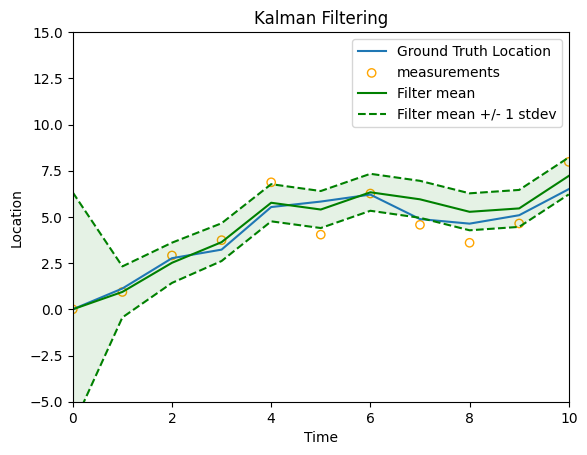

In [14]:
def visualize_kalman_test1():
    state_init = Gaussian(0, 40)
    a = 1.
    h = 1.
    square_sigma_w = 1.
    square_sigma_v = 2.
    num_step = 10

    simulator = Simulator_1d(process_var=square_sigma_w,
                             measurement_var=square_sigma_v,
                             seed=0)
    controls = [1.0 for _ in range(num_step)]
    measurements, gt_locs = map(
        list,
        zip(*[simulator.simulate_step(u, return_gt_loc=True)
              for u in controls]))

    result_list = [PlotData('init', [state_init])]

    state = state_init
    for i in range(num_step):
        result_list.append(
            PlotData(f'step_{i:02d}_process',
                     [kf_process(state, a, square_sigma_w, controls[i])]))
        state = kf(state, a, square_sigma_w, h, square_sigma_v, [controls[i]],
                   [measurements[i]])
        result_list.append(PlotData(f'step_{i:02d}_posterior', [state]))

    gt_locs.insert(0, 0)
    measurements.insert(0, 0)
    render_animation(result_list, plot_gaussian)
    plot_time(gt_locs, measurements, [
        res.data[0]
        for res in result_list
        if 'posterior' in res.name or 'init' in res.name
    ])


visualize_kalman_test1()

# Particle Filter Demo

We've implemented a simple particle filter and visualization for you based on homework problem #5.


In [15]:
class HybridSimulator_1d:
    """A simulator for a robot moving in 1D based on problem #5.
    """

    def __init__(self,
                 init_state: float = 0.0,
                 p_forward: float = 0.5,
                 process_var: float = 0.0,
                 forward_delta: float = 0.0,
                 backward_delta: float = 0.0,
                 seed = None):
        # Initial simulator state
        self.init_state = init_state
        self.process_std = np.sqrt(process_var)
        self.p_forward = p_forward
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)

        self.forward_delta = forward_delta
        self.backward_delta = backward_delta

        self.state = self.init_state

    def simulate_motion(self):
        """Simulate robot motion. This function updates the value of
        self.state.
        """
        if self.rng.random() < self.p_forward:
            u = self.forward_delta
        else:
            u = self.backward_delta
        motion_noise = self.rng.normal(0, self.process_std)
        self.state = self.state + u + motion_noise

    def simulate_sensing(self) -> float:
        """Simulate the robot sensing process. Returns a measurement of the robot's current location.
            Measurement is based on the current location, with a Gaussian noise added.

        Returns:
            measurement: a scalar representing the measurement of robot's location.
        """
        sensor_noise = self.rng.uniform(self.backward_delta, self.forward_delta)
        return self.state + sensor_noise

In [25]:
import scipy.stats
p = .5
forward_delta = 1
step_noise_var = .1
backward_delta = -1

class ParticleFilter1D:
    def __init__(self, num_particles, p):
        # initialize all particles at 0 with some noise, weighted by a uniform dist'n
        self.particles = np.random.normal(loc=0, scale=1e-3, size=num_particles)
        self.weights = np.ones(num_particles) / num_particles
        assert 0 <= p <= 1
        self.p = p
        self.rng = np.random.default_rng()

    def compute_weights(self, measurement):
        """Compute the importance weights using the observation model from the problem.

        Args:
            measurement: observed y_t, location of robot.
        """
        unif_prob = 1 / (forward_delta + abs(backward_delta))
        def likelihood(o, x):
          return unif_prob if x + backward_delta < o < x + forward_delta else 0.0

        for i, p in enumerate(self.particles):
            self.weights[i] = likelihood(measurement, p)
        if self.weights.sum() == 0:
            raise Exception(f"Aborted due to particle death (all particle weights are 0). Current measurement is {measurement}. Current particles are {sorted(np.round(self.particles, 2))}")
        self.weights /= self.weights.sum()

    def update(self, measurement):
        """Update the particles by resampling according to importance weights."""
        self.motion_model()
        self.compute_weights(measurement)
        assert len(self.particles.shape) == 1
        self.particles = np.random.choice(self.particles, p=self.weights/self.weights.sum(), size=self.particles.shape[0])
        # add noise
        self.particles = self.particles + np.random.normal(0, 1e-3, size=self.particles.shape[0])


    def motion_model(self):
        stdev = np.sqrt(step_noise_var)
        def forward_sample(x):
            step = forward_delta if np.random.random() < p else backward_delta
            return np.random.normal(x + step, stdev)
        self.particles = np.array([forward_sample(x) for x in self.particles])

def plot_particles(particles, gt, obs, label, ax):
    """Create a 1D scatterplot on y=0 to visualize the particles."""
    ax.set_title(label)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.5,0.5])
    ax.set_xlabel("Location")
    ax.scatter(particles, np.zeros_like(particles), c='green', label="Particles")
    ax.scatter(gt, 0, label="Ground truth")
    if obs is not None:
      ax.scatter(obs, 0, c='orange', label="Observation")

    ax.legend()

def render_pf_animation(data_list: List[PlotData], gt_locs, obs_list, plot_fn: Callable):
    """Render simulation as a matplotlib animation."""
    import matplotlib.animation as animation
    from IPython import display as display

    fig, ax = plt.subplots()

    def render_frame(i):
        ax.clear()
        plot_fn(*data_list[i].data, gt_locs[i], None if i == 0 else obs_list[i-1], label=data_list[i].name, ax=ax)
        return ax

    anim = animation.FuncAnimation(fig,
                                   render_frame,
                                   len(data_list),
                                   interval=1000)
    video = anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()

def pf_plot_time(gt_locs, particle_sets, obs_list, label="Particle Filtering", ax=None):
    if ax is None:
        fig,ax = plt.subplots()

    xmin = 0
    xmax = len(gt_locs)
    x = np.arange(0, xmax)

    stds = []
    means = []
    ymin=0
    ymax=1
    for ps in particle_sets:
        ymax = max(ymax, max(ps.data[0]))
        ymin = max(ymin, min(ps.data[0]))
        means.append(ps.data[0].mean())
        stds.append(ps.data[0].std())
    ymin = min(ymin, min(gt_locs))
    ymax = max(ymax, max(gt_locs))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    means = np.array(means)
    stds = np.array(stds)
    std_top = means + stds
    std_bottom = means - stds
    plt.xticks(range(0, len(gt_locs)+1))
    ax.plot(x,gt_locs, label="Ground truth")
    ax.scatter(np.arange(1, xmax), obs_list, label="Observations", color='orange', facecolor=None)
    ax.plot(x, means, label='Mean of particles', color='g')
    ax.plot(x, std_top, linestyle='--', color='g', label='+/- 1 stdev of particles')
    ax.plot(x, std_bottom, linestyle='--', color='g')
    ax.fill_between(x, std_bottom, std_top, facecolor='g', alpha=.1)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Location")
    ax.legend()
    ax.set_title(label)

def visualize_particle_filter(num_steps, num_particles):
    pf = ParticleFilter1D(num_particles, p)
    sim = HybridSimulator_1d(init_state = 0, p_forward=p, process_var = step_noise_var, forward_delta = forward_delta, backward_delta = backward_delta)
    result_list = []
    gt_locs = []
    obs_list = []
    result_list.append(PlotData(f"Init", [pf.particles]))
    gt_locs.append(sim.state)
    for i in range(num_steps):
        sim.simulate_motion()
        y = sim.simulate_sensing()
        obs_list.append(y)
        gt_locs.append(sim.state)
        pf.update(y)
        # print(f'Particles: {pf.particles}')
        result_list.append(PlotData(f"Step_{i+1}", [pf.particles]))
    render_pf_animation(result_list, gt_locs, obs_list, plot_particles)
    pf_plot_time(gt_locs, result_list, obs_list)

visualize_particle_filter(num_steps = 20, num_particles = 15)



Exception: Aborted due to particle death (all particle weights are 0). Current measurement is 8.594353420262973. Current particles are [3.92, 3.97, 4.24, 4.44, 4.53, 4.89, 4.99, 5.12, 6.28, 6.37, 6.6, 6.66, 6.75, 6.78, 6.81]